# In search of the Holy Grail

In [1]:
%matplotlib inline

In [3]:
# imports
import sys
from desispec import bootcalib as bootc
from desiutil import funcfits as dufits
#
sys.path.append(os.path.abspath("/Users/xavier/local/Python/PYPIT/src/"))
import armsgs as msgs
import ardebug
debug = ardebug.init()
last_updated = "26 November 2015"
version = '0.3'
verbose = False
msgs = msgs.get_logger((None, debug, last_updated, version, verbose))
import ararclines
import ararc as pyparc
import arutils

/Users/xavier/local/Python/PYPIT/src/arutils.py:27: UserWarning: ds9 module not installed
  warnings.warn("ds9 module not installed")


In [4]:
# LRISr
pixpk = np.array([   44.48548296,   172.89127284,   186.40595723,   194.90669321,
         205.27791998,   225.91831224,   237.75445526,   244.67787642,
         258.32024281,   284.80424904,   297.95088588,   304.32791548,
         338.93921337,   367.06152237,   380.85908214,   401.33172725,
         410.50564368,   423.48900142,   434.99430789,   457.37290774,
         488.37853661,   499.77642185,   512.47037332,   526.46054509,
         531.09374127,   548.60194487,   561.55045742,   584.23322514,
         607.38695571,   616.29664611,   638.93076161,   655.40375678,
         669.6613697 ,   696.61898826,   730.00992529,   746.09652748,
         759.13834741,   770.25572854,   792.32336615,   866.2691866 ,
         873.17420623,   882.14114981,   888.34678116,   902.1922555 ,
         924.47068438,   961.43743412,   976.85878178,   987.46838199,
        1020.05739901,  1036.93430325,  1053.50315   ,  1085.1768635 ,
        1114.722588  ,  1122.68159311,  1140.78101461,  1154.30159287,
        1159.95601591,  1176.25448288,  1183.35928052,  1217.26159628,
        1237.96559256,  1248.14347416,  1257.39153162,  1264.07798538,
        1277.12260434,  1309.02417381,  1369.4388766 ,  1375.18929295,
        1407.1859496 ,  1441.21856771,  1474.36353717,  1494.81185267,
        1510.61385111,  1520.04403868,  1532.17586078,  1544.00013256,
        1553.49714119,  1568.13495337,  1601.20827538,  1615.38852212,
        1648.8922041 ,  1682.28030842,  1692.21254363,  1738.46846657,
        1773.96586387,  1779.93551015,  1786.2796231 ,  1791.82491476,
        1799.09112006,  1852.68590012,  1866.14740391,  1872.67491904,
        1881.15295659,  1889.01947025,  1903.32590177,  1913.46875905,
        1920.45244571,  1927.45068105,  1932.74364454,  1941.98544882,
        1952.75881331,  1960.00649953,  1969.44860805,  1980.91775367,
        1989.21778856,  1998.94533717,  2025.86827108])

## ID a small subset

In [5]:
dlamb, wmark, gd_lines, line_guess = bootc.load_gdarc_lines('r',['HgI','NeI','ArI'])
dlamb = 1.6 # LRISr 600/7500
gd_lines

array([ 5771.21  ,  5854.1101,  5946.481 ,  6144.7629,  6404.018 ,
        6508.3255,  6680.1205,  6718.8974,  6931.3787,  6965.431 ,
        7034.352 ,  7175.9154,  7247.1631,  7440.9469])

In [6]:
reload(bootc)
id_dict = bootc.id_arc_lines(pixpk, gd_lines, dlamb, wmark, line_guess=37)
id_dict

{u'dlamb': 1.6,
 u'first_id_idx': [30, 35, 37, 43, 44],
 u'first_id_pix': array([ 638.93076161,  746.09652748,  770.25572854,  902.1922555 ,
         924.47068438]),
 u'first_id_wave': array([ 6508.3255,  6680.1205,  6718.8974,  6931.3787,  6965.431 ]),
 u'fit': {'coeff': array([ -3.32713531e+03,   2.98120305e-01,   5.06994823e-07]),
  'func': u'polynomial',
  'order': 2,
  'xmax': 1.0,
  'xmin': 0.0},
 'guess': 37,
 u'icen': 7,
 'im1': 35,
 'im2': 30,
 'ip1': 43,
 'ip2': 44,
 'rms': 0.32779548461765834,
 u'status': u'ok',
 u'wmark': 6718.8974}

In [7]:
# PYPIT fit
func = 'polynomial'
#func = 'legendre'
deg = 1
coeff = arutils.func_fit(id_dict['first_id_pix'], id_dict['first_id_wave'], func, deg)
#coeff = arutils.func_fit(id_dict['first_id_pix'], id_dict['first_id_wave'], func, deg,minv=0., maxv=1.)
coeff

array([  5.48379100e+03,   1.60353711e+00])

In [8]:
fdict = dict(coeff=coeff, func=func, order=len(coeff)-1, minv=0., maxv=1)

----

## Extrapolating the Solution: I. Nearest ~5 lines (each side)

In [9]:
# line list for LRISr
alist = ararclines.load_arcline_list(None,None,['ArI','NeI','HgI','KrI','XeI'],None)

[INFO]    :: Rejecting select ArI lines
[INFO]    :: Rejecting select NeI lines
[INFO]    :: Rejecting select HgI lines


In [9]:
reload(pyparc)
ex_lines, guesses, matches = pyparc.extrap_Nlines(pixpk,id_dict['first_id_idx'],
                                                  id_dict['first_id_wave'],alist['wave'],
                                                  fdict=fdict,Nextrap=10)
gdp = matches > 1.

In [10]:
# Fit original with 2 parameters about x_c
xc = np.mean(id_dict['first_id_pix'])
xc

796.38919150200002

In [11]:
xr = id_dict['first_id_pix'] - xc

In [12]:
coeffr = arutils.func_fit(xr, id_dict['first_id_wave'], func, 1)
coeffr

array([  6.76083062e+03,   1.60353711e+00])

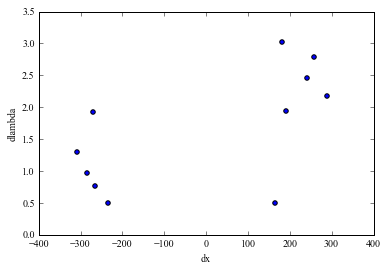

In [13]:
# Plot
xmean = np.mean(id_dict['first_id_pix'])
plt.clf()
ax = plt.gca()
gdp = matches > 1.
#ax.scatter(ex_lines[gdp]-xmean, matches[gdp]-guesses[gdp], marker='o')
dx = ex_lines[gdp]-xmean
ax.scatter(dx, (matches[gdp]-guesses[gdp]), marker='o')
ax.set_xlabel('dx')
ax.set_ylabel('dlambda')
#ax.set_ylim(-0.01,0.01)
plt.show()

In [44]:
guesses

array([ 6124.28270197,  6139.03004164,  6159.90116991,  6178.39628743,
        6214.3705429 ,  6264.21300048,  6282.53543523,  6302.94133444,
        6325.43094579,  6332.87894451,  6361.02389519,  6381.8390088 ,
        6418.30222304,  6455.52252386,  6469.84511244,  7024.66904971,
        7049.45931827,  7066.51456171,  7118.90236218,  7146.03248062,
        7172.66738762,  7223.58381084,  7271.07942934,  7283.87376344,
        7312.96911423,  7334.70384024,  7343.79349108,  7369.99375466,
        7381.4149252 ,  7435.9138919 ])

In [45]:
matches

array([    0.    ,     0.    ,     0.    ,     0.    ,  6217.2812,
        6266.4952,     0.    ,  6304.7893,  6328.1646,  6334.4276,
           0.    ,  6382.9914,     0.    ,     0.    ,     0.    ,
        7024.05  ,  7051.2922,  7067.218 ,     0.    ,  7147.042 ,
        7173.938 ,  7224.103 ,  7272.936 ,     0.    ,     0.    ,
           0.    ,     0.    ,     0.    ,  7383.98  ,  7438.8981])

In [58]:
Dlp = (matches[gdp]-coeffr[0]-coeffr[1]*(ex_lines[gdp]-xc))/(ex_lines[gdp]-xc)**2
Dlp

array([  2.40559288e-05,   2.29247979e-05,   3.75185136e-05,
         2.20036745e-05,   2.08958707e-05,  -2.27249907e-05,
         5.62764090e-05,   1.92663399e-05,   1.74470332e-05,
         1.92203712e-05,   6.22541512e-06,   1.83209115e-05])

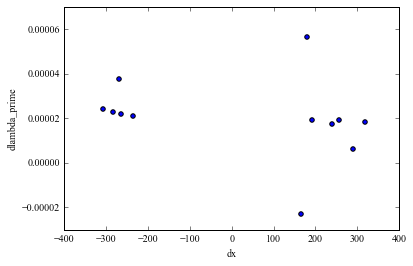

2.0081105264793145e-05

In [60]:
# Plot
plt.clf()
ax = plt.gca()
#ax.scatter(ex_lines[gdp]-xmean, matches[gdp]-guesses[gdp], marker='o')
dx = ex_lines[gdp]-xc
ax.scatter(dx, Dlp, marker='o')
ax.set_xlabel('dx')
ax.set_ylabel('dlambda_prime')
ax.set_ylim(-3e-5,7e-5)
plt.show()
np.median(Dlp)

In [61]:
Dlp_best = np.median(Dlp)

In [62]:
wave_x = coeffr[0] + coeffr[1]*(ex_lines[gdp]-xc) + Dlp_best*(ex_lines[gdp]-xc)**2

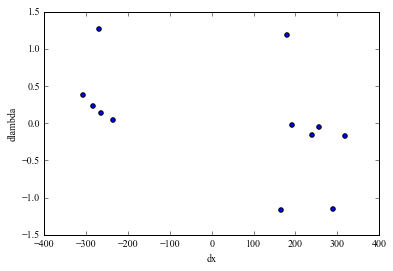

In [63]:
# Plot
plt.clf()
ax = plt.gca()
gdp = matches > 1.
#ax.scatter(ex_lines[gdp]-xmean, matches[gdp]-guesses[gdp], marker='o')
dx = ex_lines[gdp]-xc
ax.scatter(dx, (matches[gdp]-wave_x), marker='o')
ax.set_xlabel('dx')
ax.set_ylabel('dlambda')
#ax.set_ylim(-0.01,0.01)
plt.show()

In [64]:
Dlpp = (matches[gdp]-coeffr[0]-coeffr[1]*(ex_lines[gdp]-xc)-
        Dlp_best*(ex_lines[gdp]-xc)**2)/(ex_lines[gdp]-xc)**3
Dlpp

array([ -1.29048246e-08,  -1.00158654e-08,  -6.46000659e-08,
        -7.24689880e-09,  -3.46946772e-09,  -2.59355055e-07,
         2.00561788e-07,  -4.26401956e-09,  -1.09504287e-08,
        -3.34767518e-09,  -4.79788145e-08,  -5.52940346e-09])

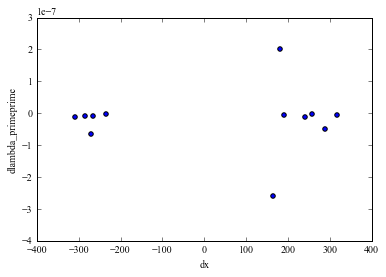

-8.6313821175294997e-09

In [65]:
# Plot
plt.clf()
ax = plt.gca()
#ax.scatter(ex_lines[gdp]-xmean, matches[gdp]-guesses[gdp], marker='o')
dx = ex_lines[gdp]-xc
ax.scatter(dx, Dlpp, marker='o')
ax.set_xlabel('dx')
ax.set_ylabel('dlambda_primeprime')
ax.set_ylim(-4e-7,3e-7)
plt.show()
np.median(Dlpp)

In [66]:
Dlpp_best = np.median(Dlpp)
wave_xx = coeffr[0] + coeffr[1]*(ex_lines[gdp]-xc) + Dlp_best*(ex_lines[gdp]-xc)**2 + Dlpp_best*(ex_lines[gdp]-xc)**3

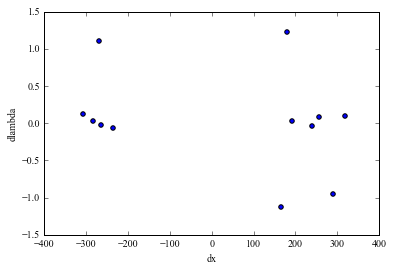

In [67]:
# Plot
plt.clf()
ax = plt.gca()
gdp = matches > 1.
#ax.scatter(ex_lines[gdp]-xmean, matches[gdp]-guesses[gdp], marker='o')
dx = ex_lines[gdp]-xc
ax.scatter(dx, (matches[gdp]-wave_xx), marker='o')
ax.set_xlabel('dx')
ax.set_ylabel('dlambda')
#ax.set_ylim(-0.01,0.01)
plt.show()

In [68]:
quads = np.zeros((4,2)).astype(int)
quads.shape

(4, 2)

In [71]:
npix = 2048

In [74]:
    pix_quad = npix//4
    quads = np.zeros((4,2)).astype(int)
    quads[:,0] = np.arange(4)*pix_quad
    quads[:,1] = (np.arange(4)+1)*pix_quad
    quads[-1,1] = min(npix,quads[-1,1])

In [75]:
quads

array([[   0,  512],
       [ 512, 1024],
       [1024, 1536],
       [1536, 2048]])

In [76]:
tmp = []*4

0

----

## Pushing on

In [76]:
%matplotlib inline

[INFO]    :: Rejecting select ArI lines
[INFO]    :: Rejecting select NeI lines
[INFO]    :: Rejecting select HgI lines
[INFO]    :: Cut a few lines to limit extrapolation
[INFO]    :: Did not exceed minimum hits for large extrapolation [bad]
[INFO]    :: Going convservative..


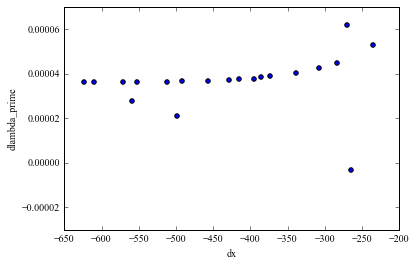

[INFO]    :: Added ID 401.332 at wavelength 6130.15 with 4 hits
[INFO]    :: Cut a few lines to limit extrapolation
[INFO]    :: Exceed minimum hits for large extrapolation [good]


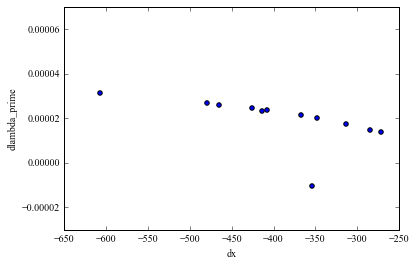

[INFO]    :: Added ID 172.891 at wavelength 5771.21 with 10 hits
[WARNING] :: Not enough matches to extrapolate (1)
[INFO]    :: Extrapolating to higher lines
[INFO]    :: Cut a few lines to limit extrapolation
[INFO]    :: Did not exceed minimum hits for large extrapolation [bad]
[INFO]    :: Going convservative..


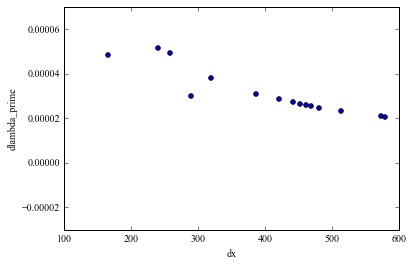

[INFO]    :: Added ID 1257.39 at wavelength 7505.94 with 5 hits
[INFO]    :: Cut a few lines to limit extrapolation
[INFO]    :: Did not exceed minimum hits for large extrapolation [bad]
[INFO]    :: Going convservative..


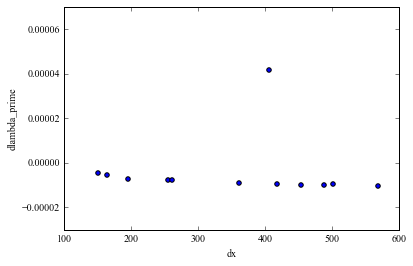

[INFO]    :: Added ID 1264.08 at wavelength 7516.72 with 12 hits
[INFO]    :: Cut a few lines to limit extrapolation
[INFO]    :: Did not exceed minimum hits for large extrapolation [bad]
[INFO]    :: Going convservative..


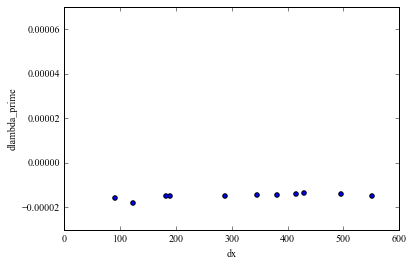

[INFO]    :: Added ID 1309.02 at wavelength 7589.5 with 12 hits
[INFO]    :: Cut a few lines to limit extrapolation
[INFO]    :: Exceed minimum hits for large extrapolation [good]


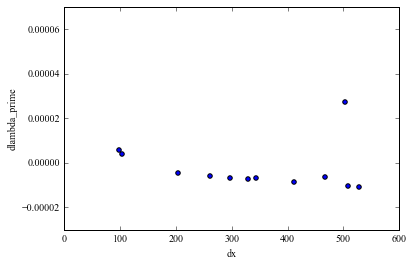

[INFO]    :: Added ID 1799.09 at wavelength 8379.91 with 10 hits
[WARNING] :: Not enough matches to extrapolate (8)
[WARNING] :: Not enough matches to extrapolate (8)
[INFO]    :: No lines available for fitting


rms = 0.464255
--Return--
> /Users/xavier/local/Python/PYPIT/src/ararc.py(2027)searching_for_the_grail()->None
-> debugger.set_trace()
(Pdb) exit


BdbQuit: 

In [14]:
reload(pyparc)
pyparc.searching_for_the_grail()

In [ ]:
tmp = np.arange(10)
tmp.sort()


----

## Read IDL save file?

In [108]:
from scipy.io.idl import readsav

In [109]:
lrisr_600 = '/Users/xavier/idl/xidl/Spec/Longslit/calib/linelists/lris_red_600_7500.sav'

In [110]:
s = readsav(lrisr_600)

In [120]:
s['calib'][2]

('CHEBY', 4, array([ 1045.,  1915.]), 2.5, 2.5, 5, 12, 12, 1, 0.7616806863824909, array([  6.60600226e+03,   1.52876588e+03,   5.00828019e+00,
        -3.67292210e+00]), 6567.2282205509955, 1.607637164946027)

In [127]:
s['archive_arc'].shape

(20, 2048)

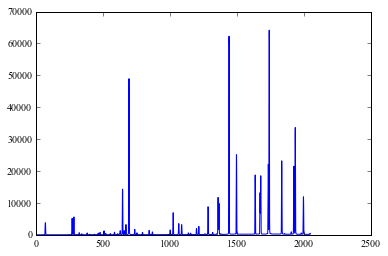

In [116]:
xdb.xplot(s['archive_arc'][0,:])

In [122]:
s

{'archive_arc': array([[  20.40959358,   41.03271484,   36.79991531, ...,  171.14596558,
          261.13537598,  434.90951538],
        [  15.60663414,   13.50810528,   10.54215717, ...,   98.07922363,
          128.99525452,  414.66860962],
        [  14.18223953,   10.97014904,   10.67464066, ...,   79.47535706,
          101.82618713,  399.8918457 ],
        ..., 
        [  14.89193821,   12.34567738,   10.73631287, ...,  473.23348999,
          171.31869507,  544.92669678],
        [  11.5486269 ,   13.5725584 ,    9.73627853, ...,   66.06369781,
           99.66627502,  532.6159668 ],
        [  20.89477921,   13.99801254,   12.71237373, ...,   69.35678101,
          104.90868378,  500.6892395 ]], dtype=float32),
 'calib': rec.array([ ('CHEBY', 4, array([ 1054.5,  1970. ]), 2.5, 2.5, 5, 12, 12, 1, 0.740902973584647, array([  7.02064567e+03,   1.56849510e+03,   5.02493816e+00,
         -3.75200666e+00]), 6966.714662333921, 1.6031207530468237),
  ('CHEBY', 4, array([ 1052.5,  1968

In [126]:
s['calib'][0]['nrm']

array([ 1054.5,  1970. ])

### Generate wavelength array

In [128]:
pix = np.arange(2048)

In [139]:
nrm = s['calib'][0]['nrm']
xnrm = 2. * (pix - nrm[0])/nrm[1]

In [137]:
def fcheby(xnrm,order):
    leg = np.zeros((len(xnrm),order))
    leg[:,0] = 1.
    if order >= 2:
        leg[:,1] = xnrm 
    # For looop
    for j in range(2,order): 
        leg[:,j] = 2.0 * xnrm * leg[:,j-1] - leg[:,j-2] 
    # Return
    return leg

In [144]:
f = fcheby(xnrm,s['calib'][0]['nord'])
f.shape

(2048, 4)

In [145]:
wave = np.dot(f,s['calib'][0]['ffit'])

In [147]:
wave

array([ 5354.33732823,  5355.86696316,  5357.39671807, ...,  8599.09438575,
        8600.67245584,  8602.25045322])

----

## Extrap vs. Linelist

In [10]:
reload(pyparc)

<module 'ararc' from '/Users/xavier/local/Python/PYPIT/src/ararc.py'>

In [11]:
# Initialize 5 good lines + fit
idlines = pyparc.init_idlines()
idlines.fit_poly(3)

In [12]:
# Read all detected lines and assign wavelegnths
pixpk = pyparc.init_pixpk()
waves = idlines.eval_poly(pixpk)

In [13]:
# Linelist
alist = ararclines.load_arcline_list(None,None,['ArI','NeI','HgI','KrI','XeI'],None)

[INFO]    :: Rejecting select ArI lines
[INFO]    :: Rejecting select NeI lines
[INFO]    :: Rejecting select HgI lines


In [14]:
# Plot wavelengths and linelist
plt.clf()
ax = plt.gca()
# Predicted lines
ymnx = (0,1)
for wave in waves:
    ax.plot([wave]*2, (0.,0.5), 'k')
# Linelist
for iwave in alist['wave']:
    ax.plot([iwave]*2, (0.,0.4), 'r')
# Axes
ax.set_ylim(ymnx)
plt.show()